In [57]:
import tensorflow as tf
import numpy as np
import math

In [58]:
sess = tf.InteractiveSession()

In [59]:
x1 = tf.Variable(tf.truncated_normal([5],mean=3,stddev = 1./math.sqrt(5)))
x2 = tf.Variable(tf.truncated_normal([5],mean=-1,stddev = 1./math.sqrt(5)))
x3 = tf.Variable(tf.truncated_normal([5],mean=0,stddev = 1./math.sqrt(5)))
sess.run(tf.global_variables_initializer())

In [60]:
sqx2 = x2 * x2
print(x2.eval(session=sess))
print(sqx2.eval(session=sess))

[-0.89748824 -0.85857099 -0.26762366 -1.04585409 -1.16145039]
[ 0.80548513  0.73714417  0.07162242  1.0938108   1.34896696]


In [61]:
logx1 = tf.log(x1)
print(x1.eval())
print(logx1.eval())

[ 3.79052639  3.07558465  3.85833526  3.20157146  2.98093176]
[ 1.33250487  1.12349498  1.35023582  1.16364181  1.09223592]


In [62]:
sigx3 = tf.sigmoid(x3)
print(x3.eval())
print(sigx3.eval())

[ 0.75457209 -0.08573563 -0.10801934  0.80168152 -0.04271995]
[ 0.68017411  0.47857919  0.47302136  0.69033402  0.48932162]


In [63]:
w1 = tf.constant(0.1)
w2 = tf.constant(0.2)
n1 = tf.sigmoid((w1*x1) + (w2*x2))
print((w1*x1).eval())
print((w2*x2).eval())
print(n1.eval())

[ 0.37905264  0.30755848  0.38583353  0.32015714  0.29809317]
[-0.17949764 -0.1717142  -0.05352473 -0.20917082 -0.23229007]
[ 0.54972386  0.53390896  0.58232105  0.52771813  0.5164448 ]


In [64]:
#single hidden layer model
import tqdm as tqdm
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x,*args,**kwargs):
        return x

In [65]:
data = np.load('data/data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']

def to_onehot(labels,nclasses = 5):
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx,training_idx=indices[:valid_cnt],indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]

## Input pixels, flattened
x = tf.placeholder("float", [None, 1296])
## Known labels
y_ = tf.placeholder("float", [None,5])

In [180]:
num_hidden1 = 128
W1 = tf.Variable(tf.truncated_normal([1296,num_hidden1],stddev=1./math.sqrt(1296)))
b1 = tf.Variable(tf.constant(0.1,shape=[num_hidden1]))

In [181]:
#first layer
h1 = tf.sigmoid(tf.matmul(x,W1)+b1)

In [186]:
num_hidden2 = 32
W2 = tf.Variable(tf.truncated_normal([num_hidden1,num_hidden2],stddev=1./math.sqrt(num_hidden1)))
b2 = tf.Variable(tf.constant(0.1,shape=[num_hidden2]))

In [187]:
#second layer
h2 = tf.sigmoid(tf.matmul(h1,W2)+b2)

In [188]:
#output layer
W3 = tf.Variable(tf.truncated_normal([num_hidden2,5],stddev=1./math.sqrt(5)))
b3 = tf.Variable(tf.constant(0.1,shape=[5]))

In [189]:
y = tf.nn.softmax(tf.matmul(h2,W3)+b3)

In [192]:
#implement pre-defined cross-entropy loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= y + 1e-50,labels = y_))
#define how to train
train_step = tf.train.GradientDescentOptimizer(0.02).minimize(cross_entropy)
#define accuracy 
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
sess.run(tf.global_variables_initializer())

In [193]:
epochs = 5000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs),ascii=True):
    if i % 10 == 0:
        A = accuracy.eval(feed_dict={
            x:train.reshape([-1,1296]),
            y_:onehot_train
        })
        train_acc[i//10] = A
        A = accuracy.eval(feed_dict={
            x:test.reshape([-1,1296]),
            y_:onehot_test
        })
        test_acc[i//10] = A
    train_step.run(feed_dict={
        x:train.reshape([-1,1296]),
        y_:onehot_train
    })

100%|##########| 5000/5000 [09:22<00:00,  8.89it/s]


In [194]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')

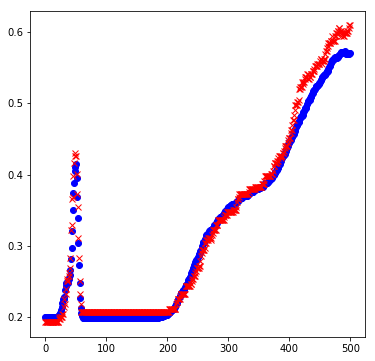

In [195]:
plt.show()

In [196]:
pred = np.argmax(y.eval(feed_dict={
    x:test.reshape([-1,1296]),
    y_:onehot_test
}),axis=1)
conf = np.zeros((5,5))
for p,t in zip(pred,np.argmax(onehot_test,axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()

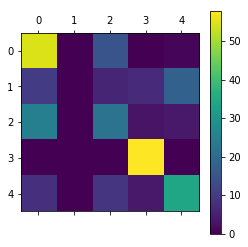

In [197]:
plt.show()

In [198]:
plt.figure(figsize=(6,6))
f,plts = plt.subplots(4,8,sharex=True)
for i in range(32):
    plts[i//8,i%8].pcolormesh(W1.eval()[:,i].reshape([36,36]))

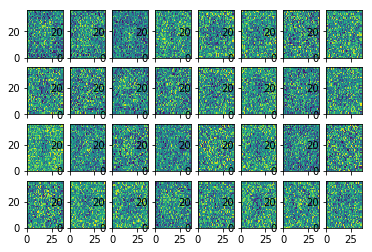

In [199]:
plt.show()